# Predicting Rating - baseline
 - data can be found [here](https://www.kaggle.com/kingburrito666/cannabis-strains)

In [1]:
!pip install category_encoders

In [0]:
import category_encoders as ce
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

##Read in data
  - download and import to notebook

In [3]:
path = 'cannabis.csv'
df = pd.read_csv(path)
df.head()

,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%..."


## Gather Info

In [4]:
# data types present
df.dtypes

Strain          object
Type            object
Rating         float64
Effects         object
Flavor          object
Description     object
dtype: object

        %  counts
4.5  0.13     317
4.3  0.13     297
4.4  0.12     284
4.6  0.10     242
4.2  0.10     225


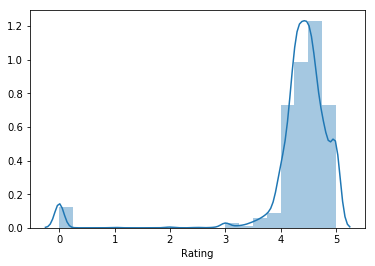

In [5]:
# distribution of values
cnts = df.Rating.value_counts(dropna=False)
perc = df.Rating.value_counts(dropna=False, normalize=True).round(2)
dist = pd.concat([perc,cnts], axis=1, keys=['%','counts'])


print(dist.head())
sns.distplot(df['Rating'], bins=20, vertical=False);


## Getting the basline
 - split into features and target
 - Use average for comparison

In [6]:
features = ['Strain', 'Type', 'Effects', 'Flavor', 'Description']
target = 'Rating'
X = df[features]
y = df[target]


# Average of ratings used to test 
y_bl = np.full_like(y, fill_value=y.mean())


# Evaluation metrics
print("Rating average:", round(y.mean(),1))
print('Test MAE:', round(mean_absolute_error(y, y_bl), 4))
print('Test RMSE:', round(sqrt(mean_squared_error(y, y_bl)),4))
print('Test R^2;', round(r2_score(y, y_bl)))

Rating average: 4.3
Test MAE: 0.4055
Test RMSE: 0.8362
Test R^2; 0.0


## Split into train/test for predictive modeling

In [0]:
# Roughly the best scoring split~
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  train_size=0.80,
                                                  test_size=0.20,
                                                  random_state=42)

## Base encoders
  - Ordinal or something comprable is necessary to deal with object data
    - works for Type column ok
    - High Cardinality on the rest
     - Try something else
  - Scaler just to see
      - doesnt actually change anything here
  - PCA because why not
    - Not much or any improvement

In [0]:
# Transform ojects to numerical representation
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)


# Center Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


# Reduce dimensionality
pca = PCA(3, random_state=42)
pca.fit(X_train)
pca_xtrain = pd.DataFrame(pca.transform(X_train))
pca_xtrain.head()
pca_xval = pd.DataFrame(pca.transform(X_val))

## Linear Regression
 - Predictions rounded to match trained target

In [16]:
# Fit and predict
lr_model = LinearRegression()
lr_model.fit(pca_xtrain, y_train)
y_pred = lr_model.predict(pca_xval)


# Round predictions
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.apply([lambda x: round(x, 1) for x in y_pred])


# Evaluation metrics
print('Baseline MAE: 0.4055')
print('Test MAE:', round(mean_absolute_error(y_val, y_pred), 4))
print('Test RMSE:', round(sqrt(mean_squared_error(y_val, y_pred)),4))
print('Test R^2;', round(r2_score(y_val, y_pred)))

Baseline MAE: 0.4055
Test MAE: 0.4648
Test RMSE: 0.8899
Test R^2; 0.0


## Beat Baseline 
 - tuned gradient boosted tree 

In [22]:
# Parameterize, fit and predict
model = XGBRegressor(n_estimators=710,
                     max_depth=1,
                     n_jobs=-1,
                     learning_rate=0.024,
                     min_child_weight=1,
                     max_delta_step=0,
                     subsample=1,
                     booster='gbtree',
                     objective='reg:squarederror',
                     eval_metric='mae',
                     random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)


# Round predictions
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.apply(lambda x: round(x,1) for x in y_pred)


# Evaluation metrics
print('Baseline MAE: 0.4055')
print('Test MAE:', round(mean_absolute_error(y_val, y_pred), 4))
print('Test MSE:', round(mean_squared_error(y_val, y_pred), 4))
print('Test RMSE:', round(sqrt(mean_squared_error(y_val, y_pred)),4))
print('Test R^2;', round(r2_score(y_val, y_pred)))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Baseline MAE: 0.4055
Test MAE: 0.3822
Test MSE: 0.4335
Test RMSE: 0.6584
Test R^2; 0.0


### 0.38 rounds to .4 so there isn't any substantial improvement